In [99]:
import numpy as np
import matplotlib.pyplot as plt
from fourier import fourier_series_coeff

In [100]:
# Numerical parameters
eps = 1e-12
N = 50
step = 5

## Global Parameters

In [101]:
# Non-dimensional parameters
# Cell length
L = 1.0

# Damkohler numbers
Dam_tr = 1.0
Dam_ci = 1.4

# Peclet numbers
Pen_tr = 10.0
Pen_ci = 15.0

Pen_tr_s = 10.0
Pen_ci_s = 15.0

# Biot numbers
Bit_tr = 1.0e3
Bit_ci = 3.33

# Marangoni numbers
Man = 1.03

# Switching rate
k_tr = 1.0
k_ci = 30 * k_tr

chi_tr = 30.0
chi_ci = 1.0

assert k_tr * chi_tr == k_ci * chi_ci

In [102]:
# Light intensity
def f_1(x):
    """A 2L-periodic light intensity perturbation."""
    
    return np.cos(np.pi * x / L) + np.sin(2 * np.pi * x / L)
    # return np.exp(-x**2 / 0.1)
    # return 1 if x > 0 else -1
    # return np.exp(-(x-0.5)**2 / 0.05) + 0.5 * np.exp(-(x+0.5)**2 / 0.1)
    

## Fourier Setup

In [103]:
# Set the frequencies
omega_full = np.arange(-N, N + 1) * np.pi / L
omega = np.concatenate([omega_full[:N], omega_full[N + 1:]])  # Excluding the zero frequency

In [104]:
# Extract Fourier coefficients
f_coeffs = fourier_series_coeff(lambda x: f_1(x - L), 2 * L, N - 1, return_complex=True)

f_o = f_coeffs[0]  # Zero mode
f_h = lambda x: np.concatenate([f_coeffs[1:][::-1].conj(), f_coeffs[1:]])  # Exclude the zero mode

f_full = lambda : np.concatenate([[f_o], f_h(omega)])

## Leading Order

### Setting Additional Parameters

In [105]:
# Setup required parameters
alpha = Dam_ci / Dam_tr
eta = Pen_tr / Pen_ci
zeta = Pen_tr * Dam_tr + Pen_ci * Dam_ci

### Apply Boundary Conditions

In [106]:
# Determinant coefficients
a_0 = k_tr * ((Dam_tr + Dam_ci) / Bit_ci + 1)

b_0 = (Dam_tr + Dam_ci) * (k_ci / Bit_tr - eta * k_tr / Bit_ci) + k_ci - eta * k_tr

In [107]:
# Quadratic coefficients
# First Quadratic
a = (a_0 + b_0 / (alpha + eta)) * (alpha + 1) / (alpha + eta)

b = b_0 * (alpha + 1) / (alpha + eta) * np.cosh(np.sqrt(zeta)) + (a_0 + b_0 / (alpha + eta)) * (1 - eta) / np.sqrt(zeta) * np.sinh(np.sqrt(zeta))

c = b_0 * (1 - eta) / np.sqrt(zeta) * np.sinh(np.sqrt(zeta)) * np.cosh(np.sqrt(zeta))

d = (alpha + 1) / (alpha + eta) + (1 / (k_tr * chi_tr) - 1 / (2 * L)) * (a_0 + b_0 / (alpha + eta))

e = (1 - eta) / np.sqrt(zeta) * np.sinh(np.sqrt(zeta)) + b_0 * (1 / (k_tr * chi_tr) - 1 / (2 * L)) * np.cosh(np.sqrt(zeta))

f = -1 / (2 * L)

# Second Quadratic
p = k_ci * chi_ci * b_0 * (alpha + eta) / np.sqrt(zeta) * np.sinh(np.sqrt(zeta)) * np.cosh(np.sqrt(zeta))

q = k_ci * chi_ci * (a_0 + b_0 / (alpha + eta)) * (alpha + eta) / np.sqrt(zeta) * np.sinh(np.sqrt(zeta))

r = k_ci * chi_ci * (alpha + eta) / np.sqrt(zeta) * np.sinh(np.sqrt(zeta)) + (alpha * k_ci + eta * k_tr) * np.cosh(np.sqrt(zeta))

s = alpha / (alpha + eta) * (k_ci - k_tr)

In [108]:
# Solve for B_0
poly = np.poly1d([
    a * p**2 - b * p * q + c * q**2,
    2 * a * p * r - b * p * s - b * q * r + 2 * c * q * s - d * p * q + e * q**2,
    a * r**2 - b * r * s + c * s**2 - d * p * s - d * q * r + 2 * e * q * s  + f * q**2,
    -d * r * s + e * s**2 + 2 * f * q * s,
    f * s**2
])
roots = poly.r

print(roots)

[ 9.50081604e+11 -2.31814268e-03  1.60950162e-03 -6.19364284e-04]


In [109]:
# Select a root
B_0 = roots[3]

In [110]:
# Solve for B_0
A_0 = -(p * B_0 + r) / (q * B_0 + s) * B_0

### Solutions to Leading Order

In [111]:
# Bulk concentrations
def c_ci_0(y):
    return A_0 / (alpha + eta) + B_0 * np.cosh(y * np.sqrt(zeta))

def c_tr_0(y):
    return A_0 - eta * c_ci_0(y)

# Surface concentrations
Delta = (Dam_tr + Dam_ci) * (k_tr * c_tr_0(1) / Bit_ci + k_ci * c_ci_0(1) / Bit_tr) + k_tr * c_tr_0(1) + k_ci * c_ci_0(1) + 1

gamma_0 = (
    (1 / Delta) * ((k_tr * c_tr_0(1) / Bit_ci + k_ci * c_ci_0(1) / Bit_tr) * np.array([Dam_ci, Dam_tr])
    + np.array([k_tr * c_tr_0(1), k_ci * c_ci_0(1)]))
)

gamma_tr_0 = gamma_0[0]
gamma_ci_0 = gamma_0[1]

assert abs((gamma_tr_0 + gamma_ci_0) - (1 - 1 / Delta)) < eps

In [112]:
# Useful functions for first order
def c_0(y):
    return np.array([c_tr_0(y), c_ci_0(y)])

def d_c_ci_0(y):
    return B_0 * np.sqrt(zeta) * np.cosh(y * np.sqrt(zeta))

def d_c_tr_0(y):
    return -eta * d_c_ci_0(y)

def d_c_0(y):
    return np.array([d_c_ci_0(y), d_c_tr_0(y)])

def d2_c_ci_0(y):
    return B_0 * zeta * np.sinh(y * np.sqrt(zeta))

def d2_c_tr_0(y):
    return -eta * d2_c_ci_0(y)

def d2_c_0(y):
    return np.array([d2_c_ci_0(y), d2_c_tr_0(y)])

### Solution Plots to Leading Order

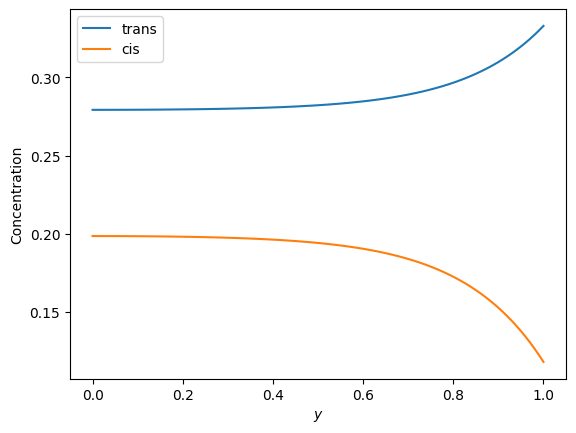

In [113]:
yy = np.linspace(0, 1, 100)

plt.plot(yy, c_tr_0(yy), label="trans")
plt.plot(yy, c_ci_0(yy), label="cis")
plt.xlabel(r"$y$")
plt.ylabel("Concentration")
plt.legend()
plt.show()

## First Order

### Setup Constants

In [114]:
# Define matrices
D = np.array([
    [Dam_tr, -Dam_ci],
    [-Dam_tr, Dam_ci]
])

P = np.array([
    [Pen_tr, 0],
    [0, Pen_ci]
])

P_s = np.array([
    [Pen_tr_s, 0],
    [0, Pen_ci_s]
])

B = np.array([
    [Bit_tr, 0],
    [0, Bit_ci]
])

K = np.array([
    [k_tr, 0],
    [0, k_ci]
])

V = np.array([
    [alpha, eta],
    [1, -1]
])

Lambda = np.array([
    [0, 0],
    [0, zeta]
])

A = P @ D

M = D + B @ np.array([
    [k_tr * c_tr_0(1) + 1, k_tr * c_tr_0(1)],
    [k_ci * c_ci_0(1), k_ci * c_ci_0(1) + 1]
])

A_s = P_s @ D

M_s = P_s @ M

z = np.ones(2).reshape(1, 2)

I = np.eye(2)

### Expand Solutions in Terms of Unknown Parameters $\omega \neq 0$

In [115]:
unknowns = ["A_h", "B_h", "C_h", "D_h", "E_h", "F_h", "G_h", "H_h", "gamma_tr_h", "gamma_ci_h", "S_h", "J_tr_h", "J_ci_h", "const"]

def to_arr(vals, omega):
    """Converts a dictionary of values to an array."""
    arr = np.zeros((len(unknowns), len(omega)), dtype=complex)
    for key in vals.keys():
        if key not in unknowns:
            raise ValueError(f"Unknown key: {key}")

    for i, key in enumerate(unknowns):
        try:
            arr[i, :] = vals[key]
        except KeyError:
            pass
    
    return arr

In [116]:
# Inverse of Lambda matrix
def Lambda_inv_h(omega):
    const = to_arr({"const": 1}, omega)

    return np.array([
        [1 / omega**2 * const, 0 * const],
        [0 * const, 1 / (omega**2 + zeta) * const]
    ])

In [117]:
# Streamfunction
def psi_h(omega, y):
    return to_arr({
        "A_h": y * np.exp(omega * y),
        "B_h": np.exp(omega * y),
        "C_h": y * np.exp(-omega * y),
        "D_h": np.exp(-omega * y),
    }, omega)

def d_psi_h(omega, y):
    return to_arr({
        "A_h": (1 + omega * y) * np.exp(omega * y),
        "B_h": omega * np.exp(omega * y),
        "C_h": (1 - omega * y) * np.exp(-omega * y),
        "D_h": -omega * np.exp(-omega * y),
    }, omega)

def d2_psi_h(omega, y):
    return to_arr({
        "A_h": omega * (2 + omega * y) * np.exp(omega * y),
        "B_h": omega**2 * np.exp(omega * y),
        "C_h": -omega * (2 - omega * y) * np.exp(-omega * y),
        "D_h": omega**2 * np.exp(-omega * y),
    }, omega)

def d3_psi_h(omega, y):
    return to_arr({
        "A_h": omega**2 * (3 + omega * y) * np.exp(omega * y),
        "B_h": omega**3 * np.exp(omega * y),
        "C_h": omega**2 * (3 - omega * y) * np.exp(-omega * y),
        "D_h": -omega**3 * np.exp(-omega * y),
    }, omega)

In [118]:
# Define coefficients for bulk concentration
def a_p_1(omega):
    return (1 / (2 * omega * np.sqrt(zeta) + zeta)) * to_arr({
        "A_h": 1,
    }, omega)

def b_p_1(omega):
    return (1 / (2 * omega * np.sqrt(zeta) + zeta)**2) * to_arr({
        "A_h": -2 * (omega + np.sqrt(zeta)),
        "B_h": 2 * omega * np.sqrt(zeta) + zeta,
    }, omega)

def c_p_1(omega):
    return (1 / (2 * omega * np.sqrt(zeta) - zeta)) * to_arr({
        "A_h": 1,
    }, omega)

def d_p_1(omega):
    return (1 / (2 * omega * np.sqrt(zeta) - zeta)**2) * to_arr({
        "A_h": 2 * (omega - np.sqrt(zeta)),
        "B_h": 2 * omega * np.sqrt(zeta) - zeta,
    }, omega)

def e_p_1(omega):
    return (1 / (2 * omega * np.sqrt(zeta) - zeta)) * to_arr({
        "C_h": -1,
    }, omega)

def f_p_1(omega):
    return (1 / (2 * omega * np.sqrt(zeta) - zeta)**2) * to_arr({
        "C_h": 2 * (omega - np.sqrt(zeta)),
        "D_h": -(2 * omega * np.sqrt(zeta) - zeta),
    }, omega)

def g_p_1(omega):
    return (1 / (2 * omega * np.sqrt(zeta) + zeta)) * to_arr({
        "C_h": -1,
    }, omega)

def h_p_1(omega):
    return (1 / (2 * omega * np.sqrt(zeta) + zeta)**2) * to_arr({
        "C_h": -2 * (omega + np.sqrt(zeta)),
        "D_h": -(2 * omega * np.sqrt(zeta) + zeta),
    }, omega)

In [119]:
# Define coefficients for bulk concentration
def a_p_2(omega):
    return (1 / (2 * omega * np.sqrt(zeta))) * to_arr({
        "A_h": 1,
    }, omega)

def b_p_2(omega):
    return (1 / (2 * omega * np.sqrt(zeta))**2) * to_arr({
        "A_h": -2 * (omega + np.sqrt(zeta)),
        "B_h": 2 * omega * np.sqrt(zeta),
    }, omega)

def c_p_2(omega):
    return (1 / (2 * omega * np.sqrt(zeta))) * to_arr({
        "A_h": 1,
    }, omega)

def d_p_2(omega):
    return (1 / (2 * omega * np.sqrt(zeta))**2) * to_arr({
        "A_h": 2 * (omega - np.sqrt(zeta)),
        "B_h": 2 * omega * np.sqrt(zeta),
    }, omega)

def e_p_2(omega):
    return (1 / (2 * omega * np.sqrt(zeta))) * to_arr({
        "C_h": -1,
    }, omega)

def f_p_2(omega):
    return (1 / (2 * omega * np.sqrt(zeta))**2) * to_arr({
        "C_h": 2 * (omega - np.sqrt(zeta)),
        "D_h": -2 * omega * np.sqrt(zeta),
    }, omega)

def g_p_2(omega):
    return (1 / (2 * omega * np.sqrt(zeta))) * to_arr({
        "C_h": -1,
    }, omega)

def h_p_2(omega):
    return (1 / (2 * omega * np.sqrt(zeta))**2) * to_arr({
        "C_h": -2 * (omega + np.sqrt(zeta)),
        "D_h": -2 * omega * np.sqrt(zeta),
    }, omega)

In [120]:
# Bulk concentration
def p_h_0(omega, y):
    eq_1 = to_arr({
        "E_h": np.sinh(omega * y),
        "F_h": np.cosh(omega * y),
    }, omega)
    eq_2 = to_arr({
        "G_h": np.sinh(np.sqrt(zeta + omega**2) * y),
        "H_h": np.cosh(np.sqrt(zeta + omega**2) * y),
    }, omega)

    return np.array([eq_1, eq_2])

def p_h_1(omega, y):
    vec = (Lambda @ np.linalg.inv(V)) @ np.array([A_0, 0]) 
    eq_1 = np.einsum("ij...,j->i...", Lambda_inv_h(omega), vec)

    return -f_h(omega) * eq_1

def p_h_2(omega, y):
    p_1 = to_arr({
        "const": -(
            A_0 / ((alpha + eta) * omega**2)
            + B_0 / (omega**2 - zeta) * np.cosh(y * np.sqrt(zeta))
        ),
    }, omega)
    p_2 = to_arr({
        "const": -(
            A_0 / ((alpha + eta) * (omega**2 + zeta))
            + B_0 / omega**2 * np.cosh(y * np.sqrt(zeta))
        ),
    }, omega)
    zero = to_arr(dict(), omega)

    matr = np.array([
        [p_1, zero],
        [zero, p_2]
    ])
    vec = Lambda @ np.linalg.inv(V) @ np.array([-eta, 1])

    return f_h(omega) * np.einsum("ij...,j->i...", matr, vec)

def p_h_3_1(omega, y):
    return (
        (a_p_1(omega) * y + b_p_1(omega)) * np.exp((omega + np.sqrt(zeta)) * y)
        + (c_p_1(omega) * y + d_p_1(omega)) * np.exp((omega - np.sqrt(zeta)) * y)
        + (e_p_1(omega) * y + f_p_1(omega)) * np.exp(-(omega - np.sqrt(zeta)) * y)
        + (g_p_1(omega) * y + h_p_1(omega)) * np.exp(-(omega + np.sqrt(zeta)) * y)
    )

def p_h_3_2(omega, y):
    return (
        (a_p_2(omega) * y + b_p_2(omega)) * np.exp((omega + np.sqrt(zeta)) * y)
        + (c_p_2(omega) * y + d_p_2(omega)) * np.exp((omega - np.sqrt(zeta)) * y)
        + (e_p_2(omega) * y + f_p_2(omega)) * np.exp(-(omega - np.sqrt(zeta)) * y)
        + (g_p_2(omega) * y + h_p_2(omega)) * np.exp(-(omega + np.sqrt(zeta)) * y)
    )

def p_h_3(omega, y):
    zero = to_arr(dict(), omega)

    matr = np.array([
        [p_h_3_1(omega, y), zero],
        [zero, p_h_3_2(omega, y)]
    ])
    vec = np.linalg.inv(V) @ P @ np.array([-eta, 1])

    return -(1.j * omega * B_0 * np.sqrt(zeta)) / 2 * np.einsum("ij...,j->i...", matr, vec)
    

def p_h(omega, y):
    return p_h_0(omega, y) + p_h_1(omega, y) + p_h_2(omega, y) + p_h_3(omega, y)

In [121]:
# Bulk concentration derivatives
def d_p_h_0(omega, y):
    eq_1 = omega * to_arr({
        "E_h": np.cosh(omega * y),
        "F_h": np.sinh(omega * y),
    }, omega)
    eq_2 = np.sqrt(zeta + omega**2) * to_arr({
        "G_h": np.cosh(np.sqrt(zeta + omega**2) * y),
        "H_h": np.sinh(np.sqrt(zeta + omega**2) * y),
    }, omega)

    return np.array([eq_1, eq_2])

def d_p_h_2(omega, y):
    d_p_1 = to_arr({
        "const": -B_0 * np.sqrt(zeta) / (omega**2 - zeta) * np.sinh(y * np.sqrt(zeta)),
    }, omega)
    d_p_2 = to_arr({
        "const": -B_0 * np.sqrt(zeta) / omega**2 * np.sinh(y * np.sqrt(zeta)),
    }, omega)
    zero = to_arr(dict(), omega)

    matr = np.array([
        [d_p_1, zero],
        [zero, d_p_2]
    ])
    vec = Lambda @ np.linalg.inv(V) @ np.array([-eta, 1])

    return f_h(omega) * np.einsum("ij...,j->i...", matr, vec)

def d_p_h_3_1(omega, y):
    return (
        a_p_1(omega) * np.exp((omega + np.sqrt(zeta)) * y)
        + c_p_1(omega) * np.exp((omega - np.sqrt(zeta)) * y)
        + e_p_1(omega) * np.exp(-(omega - np.sqrt(zeta)) * y)
        + g_p_1(omega) * np.exp(-(omega + np.sqrt(zeta)) * y)
    ) + (
        (omega + np.sqrt(zeta)) * (a_p_1(omega) * y + b_p_1(omega)) * np.exp((omega + np.sqrt(zeta)) * y)
        + (omega - np.sqrt(zeta)) * (c_p_1(omega) * y + d_p_1(omega)) * np.exp((omega - np.sqrt(zeta)) * y)
        - (omega - np.sqrt(zeta)) * (e_p_1(omega) * y + f_p_1(omega)) * np.exp(-(omega - np.sqrt(zeta)) * y)
        - (omega + np.sqrt(zeta)) * (g_p_1(omega) * y + h_p_1(omega)) * np.exp(-(omega + np.sqrt(zeta)) * y)
    )

def d_p_h_3_2(omega, y):
    return (
        a_p_2(omega) * np.exp((omega + np.sqrt(zeta)) * y)
        + c_p_2(omega) * np.exp((omega - np.sqrt(zeta)) * y)
        + e_p_2(omega) * np.exp(-(omega - np.sqrt(zeta)) * y)
        + g_p_2(omega) * np.exp(-(omega + np.sqrt(zeta)) * y)
    ) + (
        (omega + np.sqrt(zeta)) * (a_p_2(omega) * y + b_p_2(omega)) * np.exp((omega + np.sqrt(zeta)) * y)
        + (omega - np.sqrt(zeta)) * (c_p_2(omega) * y + d_p_2(omega)) * np.exp((omega - np.sqrt(zeta)) * y)
        - (omega - np.sqrt(zeta)) * (e_p_2(omega) * y + f_p_2(omega)) * np.exp(-(omega - np.sqrt(zeta)) * y)
        - (omega + np.sqrt(zeta)) * (g_p_2(omega) * y + h_p_2(omega)) * np.exp(-(omega + np.sqrt(zeta)) * y)
    )

def d_p_h_3(omega, y):
    zero = to_arr(dict(), omega)

    matr = np.array([
        [d_p_h_3_1(omega, y), zero],
        [zero, d_p_h_3_2(omega, y)]
    ])
    vec = np.linalg.inv(V) @ P @ np.array([-eta, 1])

    return -(1.j * omega * B_0 * np.sqrt(zeta)) / 2 * np.einsum("ij...,j->i...", matr, vec)
    

def d_p_h(omega, y):
    return d_p_h_0(omega, y) + d_p_h_2(omega, y) + d_p_h_3(omega, y)

In [122]:
# Revert to c
def c_h(omega, y):
    return np.einsum("ij,j...->i...", V, p_h(omega, y))

def d_c_h(omega, y):
    return np.einsum("ij,j...->i...", V, d_p_h(omega, y))

### Apply Boundary Conditions

In [123]:
# No-slip, no-penetration conditions
def no_slip(omega):
    return np.array([d_psi_h(omega, 0), omega * psi_h(omega, 0)])

In [124]:
# Kinematic condition
def kinematic(omega):
    return np.array([psi_h(omega, 1)])

In [125]:
# Normal stress balance
def normal_stress(omega):
    lhs = d3_psi_h(omega, 1) - 3 * omega**2 * d_psi_h(omega, 1)
    rhs = 1.j * omega**3 * (1 - Man * np.log(Delta)) * to_arr({
        "S_h": 1,
    }, omega)

    return np.array([lhs - rhs])

In [126]:
# No-flux condition
def no_flux(omega):
    return d_c_h(omega, 0)

In [127]:
# Kinentic fluxes
def kin_fluxes(omega):
    J_vec = np.array([to_arr({"J_tr_h": 1}, omega), to_arr({"J_ci_h": 1}, omega)])
    S_vec = np.tile(to_arr({"S_h": 1}, omega), (2, 1, 1))
    gamma_vec = np.array([to_arr({"gamma_tr_h": 1}, omega), to_arr({"gamma_ci_h": 1}, omega)])

    eq_1 = c_h(omega, 1) + np.einsum("i...,i->i...", S_vec, d_c_0(1))
    eq_2 = 1 / Delta * np.einsum("ij,j...->i...", K, eq_1)

    eq_3 = np.tile(gamma_vec[0] + gamma_vec[1], (2, 1, 1))
    eq_4 = np.einsum("i,i...->i...", c_0(1), eq_3)
    eq_5 = np.einsum("ij,j...->i...", K, eq_4)

    rhs = np.einsum("ij,j...->i...", B, eq_2 - eq_5 - gamma_vec)

    return J_vec - rhs

In [128]:
# Surface excess concentration equations
def surf_excess(omega):
    gamma_vec = np.array([to_arr({"gamma_tr_h": 1}, omega), to_arr({"gamma_ci_h": 1}, omega)])
    J_vec = np.array([to_arr({"J_tr_h": 1}, omega), to_arr({"J_ci_h": 1}, omega)])
    f_vec = np.tile(to_arr({"const": f_h(omega)}, omega), (2, 1, 1))

    d_psi_vec = np.tile(d_psi_h(omega, 1), (2, 1, 1))
    eq_1 = 1.j * omega * np.einsum("i,i...->i...", P_s @ gamma_0, d_psi_vec)

    eq_2 = omega**2 * gamma_vec

    eq_3 = -J_vec
    
    eq_4 = gamma_vec + np.einsum("i...,i->i...", f_vec, gamma_0)
    eq_5 = np.einsum("ij,j...->i...", A_s, eq_4)

    return eq_1 + eq_2 + eq_3 + eq_5

In [129]:
# Tangential stress balance
def tangential_stress(omega):
    lhs = d2_psi_h(omega, 1) + omega**2 * psi_h(omega, 1)
    rhs = -1.j * omega * Man * Delta * to_arr({
        "gamma_tr_h": 1,
        "gamma_ci_h": 1,
    }, omega)

    return np.array([lhs - rhs])

In [130]:
# Mass balance
def mass_balance(omega):
    J_vec = np.array([to_arr({"J_tr_h": 1}, omega), to_arr({"J_ci_h": 1}, omega)])
    S_vec = np.tile(to_arr({"S_h": 1}, omega), (2, 1, 1))

    eq_1 = d_p_h(omega, 1) + np.einsum("i...,i->i...", S_vec, d2_c_0(1))
    lhs = k_tr * chi_tr * eq_1

    rhs = -np.einsum("ij,j...->i...", P, J_vec)

    return lhs - rhs

In [131]:
# Collate equations
def form_equations(omega):
    return np.concatenate([
        no_slip(omega),
        kinematic(omega),
        normal_stress(omega),
        no_flux(omega),
        kin_fluxes(omega),
        surf_excess(omega),
        tangential_stress(omega),
        mass_balance(omega),
    ], axis=0)

### Solutions for Constants of Integration

In [132]:
# Form linear system for the unknowns
sys = form_equations(omega)
forcing = sys[:, -1, :]

In [133]:
# Compute unknowns
sols = np.array([np.linalg.solve(sys[:, :-1, i], -forcing[:, i]) for i in range(2 * N)])

### Test Against Analytical Solutions

In [134]:
assert np.allclose(sols[:, 1], -(sols[:, 0] * np.sinh(omega)) / (np.sinh(omega) - omega * np.exp(-omega)))  # Check for B_h

### Expand Solutions in Terms of Unknown Parameters $\omega = 0$

In [136]:
unknowns_o = ["A_h", "B_h", "C_h", "A_1", "B_1", "gamma_tr_h", "gamma_ci_h", "const"]

def to_arr_o(vals):
    """Converts a dictionary of values to an array."""
    arr = np.zeros((len(unknowns_o), 1), dtype=complex)
    for key in vals.keys():
        if key not in unknowns_o:
            raise ValueError(f"Unknown key: {key}")

    for i, key in enumerate(unknowns_o):
        try:
            arr[i, :] = vals[key]
        except KeyError:
            pass
    
    return arr

In [138]:
# Streamfunction
def psi_o(y):
    return to_arr_o({
        "A_h": y**2,
        "B_h": y,
        "C_h": 1,
    })

def d_psi_o(y):
    return to_arr_o({
        "A_h": 2 * y,
        "B_h": 1,
    })

def d2_psi_o(y):
    return to_arr_o({
        "A_h": 2,
    })

In [139]:
# Bulk concentration
def c_ci_o(y):
    return to_arr_o({
        "A_1": 1 / (alpha + eta),
        "B_1": np.cosh(y * np.sqrt(zeta)),
        "const": -f_o * B_0 * np.cosh(y * np.sqrt(zeta))
    })

def c_tr_o(y):
    return to_arr_o({"A_1": 1}) - eta * c_ci_o(y)

def c_o(y):
    return np.array([c_tr_o(y), c_ci_o(y)])

def d_c_ci_o(y):
    return to_arr_o({
        "B_1": np.sqrt(zeta) * np.sinh(y * np.sqrt(zeta)),
        "const": -f_o * B_0 * np.sqrt(zeta) * np.sinh(y * np.sqrt(zeta))
    })

def d_c_tr_o(y):
    return -eta * d_c_ci_o(y)

def d_c_o(y):
    return np.array([d_c_tr_o(y), d_c_ci_o(y)])

def i_c_ci_o():
    return to_arr_o({
        "A_1": 1 / (alpha + eta),
        "B_1": np.sinh(np.sqrt(zeta)) / np.sqrt(zeta),
        "const": -f_o * B_0 * np.sinh(np.sqrt(zeta)) / np.sqrt(zeta)
    })

def i_c_tr_o():
    return to_arr_o({"A_1": 1}) - eta * i_c_ci_o()

def i_c_o():
    return np.array([i_c_tr_o(), i_c_ci_o()])
    

### Apply Boundary Conditions

In [140]:
# No-slip, no-penetration conditions
no_slip_o = np.array([d_psi_o(0), psi_o(0)])

In [142]:
# Surface excess concentration equations
gamma_vec = np.array([
    to_arr_o({"gamma_tr_h": 1}), to_arr_o({"gamma_ci_h": 1})
])
f_vec = np.tile(to_arr_o({"const": f_o}), (2, 1, 1))

eq_1 = np.einsum("ij,j...->i...", M, gamma_vec)

eq_2 = 1 / Delta * np.einsum("ij,j...->i...", B @ K, c_o(1))

eq_3 = -np.einsum("i...,i->i...", f_vec, D @ gamma_0)

surf_excess_o = eq_1 - eq_2 - eq_3

In [143]:
# Tangential stress balance
tangential_stress_o = np.array([d2_psi_o(1)])

In [144]:
# Mass balance
gamma_tr_vec = to_arr_o({"gamma_tr_h": 1})
gamma_ci_vec = to_arr_o({"gamma_ci_h": 1})

lhs = k_ci * chi_ci * d_c_ci_o(1)

rhs = Pen_ci * (Dam_tr * gamma_tr_vec - Dam_ci * gamma_ci_vec)

mass_balance_o = np.array([lhs - rhs])

In [145]:
# Integral conditions
gamma_vec = to_arr_o({
    "gamma_tr_h": 1,
    "gamma_ci_h": 1,
})

integral_o = np.array([gamma_vec / (k_tr * chi_tr) + i_c_tr_o() + i_c_ci_o()])

In [146]:
# Collate equations
sys_o = np.concatenate([
    no_slip_o,
    surf_excess_o,
    tangential_stress_o,
    mass_balance_o,
    integral_o,
], axis=0)[:, :, 0]
forcing_o = sys_o[:, -1]

In [147]:
# Compute unknowns
sols_o = np.linalg.solve(sys_o[:, :-1], -forcing_o)

### Test against analytic solutions

In [148]:
# TODO: Update tests

In [ ]:
assert sols_o[1] == -1.5 * sols_o[0]  # B_h = -3/2 A_h
assert abs(sols_o[4]) < eps  # E_h = 0
assert abs(sols_o[6]) < eps  # G_h = 0
assert abs(sols_o[-1]) < eps  # S_h = 0
assert np.sum(J_o[:, :-1, 0] @ sols_o[:, np.newaxis] + J_o[:, -1, :]) < eps  # J_tr + J_ci = 0
assert np.allclose([
    np.dot((np.tensordot(U, d_p_o(y), axes=1)[:, :-1, 0] @ sols_o[:, np.newaxis]
            + np.tensordot(U, d_p_o(y), axes=1)[:, -1, :]).flatten(), np.array([1, eta]))
    for y in np.linspace(0, 1, 10)
], 0)  # d_c_tr + eta * d_c_ci = 0

### Solutions to First Order

In [150]:
def psi_f(y):
    val_o = psi_o(y)
    val_h = psi_h(omega, y)
    return np.concatenate([
        [val_o[:-1, 0] @ sols_o + val_o[-1, 0]],
        np.einsum("ij,ji->i", sols, val_h[:-1]) + val_h[-1],
    ])

def u_f(y):
    val_o = d_psi_o(y)
    val_h = d_psi_h(omega, y)
    return np.concatenate([
        [val_o[:-1, 0] @ sols_o + val_o[-1, 0]],
        np.einsum("ij,ji->i", sols, val_h[:-1] + val_h[-1]),
    ])

def v_f(y):
    val_h = psi_h(omega, y)
    return np.concatenate([
        [0],
        -1.j * omega * (np.einsum("ij,ji->i", sols, val_h[:-1]) + val_h[-1]),
    ])

def c_f(y):
    val_o = c_o(y)
    val_h = c_h(omega, y)
    return np.concatenate([
        (val_o[:, :-1, 0] @ sols_o)[:, np.newaxis] + val_o[:, -1],
        np.einsum("ijk,kji->ki", np.tile(sols[:, :-1, np.newaxis], (1, 1, 2)), val_h[:, -1:, :]) + val_h[:, -1],
    ], axis=1)

def c_tr_f(y):
    return c_f(y)[0]

def c_ci_f(y):
    return c_f(y)[1]

def gamma_tr_f():
    return np.concatenate([
        [sols_o[-2]],
        sols[:, -5],
    ])

def gamma_ci_f():
    return np.concatenate([
        [sols_o[-1]],
        sols[:, -4],
    ])

def S_f():
    return np.concatenate([
        [0],
        sols[:, -3],
    ])

In [151]:
def invert(f):
    def _(x, *args):
        coeffs = f(*args)
        return coeffs[0] + np.sum(coeffs[1:, np.newaxis] * np.exp(1.j * omega[:, np.newaxis] * (x + L)[np.newaxis, :]), axis=0)

    return _

In [152]:
psi = invert(psi_f)
u = invert(u_f)
v = invert(v_f)
c_tr = invert(c_tr_f)
c_ci = invert(c_ci_f)
gamma_tr = invert(gamma_tr_f)
gamma_ci = invert(gamma_ci_f)
S = invert(S_f)

f_inv = invert(f_full)

In [153]:
xx = np.linspace(-L, L, 100)
yy = np.linspace(0, 1, 100)

In [154]:
psii = np.array([psi(xx, y) for y in yy])
uu = np.array([u(xx, y) for y in yy])
vv = np.array([v(xx, y) for y in yy])
cc_tr = np.array([c_tr(xx, y) for y in yy])
cc_ci = np.array([c_ci(xx, y) for y in yy])

ggamma_tr = gamma_tr(xx)
ggamma_ci = gamma_ci(xx)
SS = S(xx)

ff_inv = f_inv(xx)

### Solution plots

#### Interfacial values

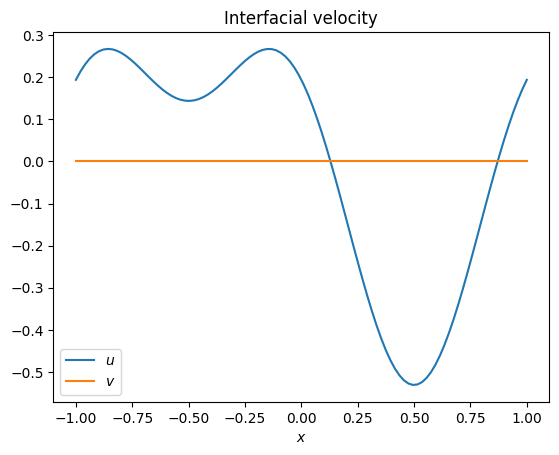

In [155]:
plt.plot(xx, uu[-1, :].real, label=r"$u$")
plt.plot(xx, vv[-1, :].real, label=r"$v$")
plt.title("Interfacial velocity")
plt.xlabel(r"$x$")
plt.legend()
plt.show()

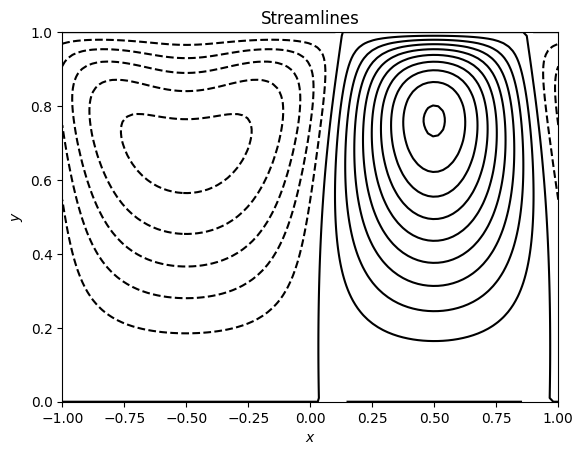

In [156]:
plt.contour(xx, yy, psii.real, levels=15, colors="black")
plt.title(r"Streamlines")
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.show()

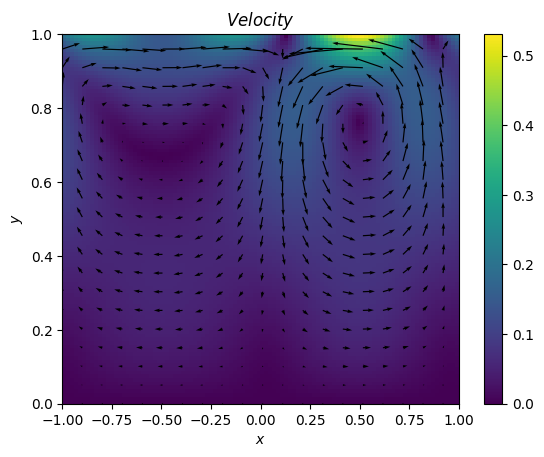

In [157]:
plt.quiver(xx[::step], yy[::step], uu[::step, ::step].real, vv[::step, ::step].real)

plt.imshow(np.sqrt(uu[::-1, :].real**2 + vv[::-1, :].real**2), extent=[-L, L, 0, 1], aspect="auto")
plt.colorbar()

plt.title(r"$Velocity$")
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.show()

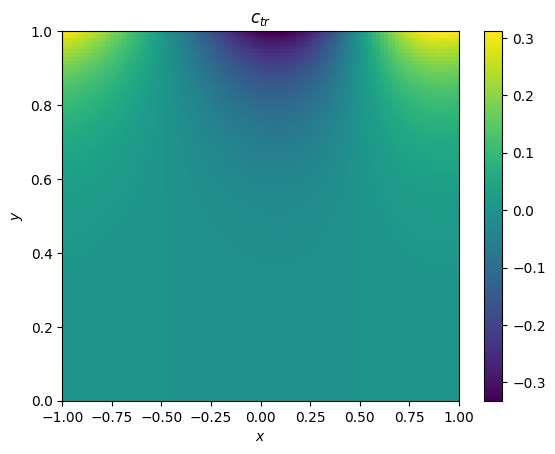

In [158]:
plt.imshow(cc_tr[::-1, :].real, extent=[-L, L, 0, 1], aspect="auto")
plt.colorbar()
plt.title(r"$c_{tr}$")
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.show()

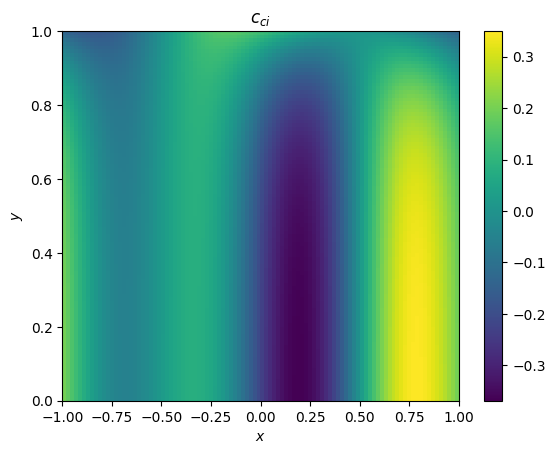

In [ ]:
plt.imshow(cc_ci[::-1, :].real, extent=[-L, L, 0, 1], aspect="auto")
plt.colorbar()
plt.title(r"$c_{ci}$")
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.show()

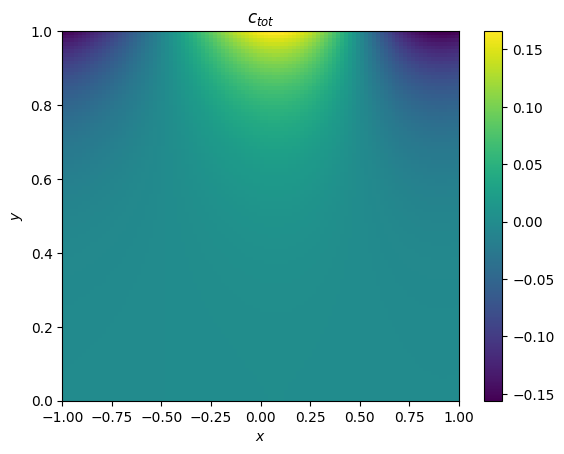

In [159]:
plt.imshow(cc_ci[::-1, :].real + cc_tr[::-1, :].real, extent=[-L, L, 0, 1], aspect="auto")
plt.colorbar()
plt.title(r"$c_{tot}$")
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.show()

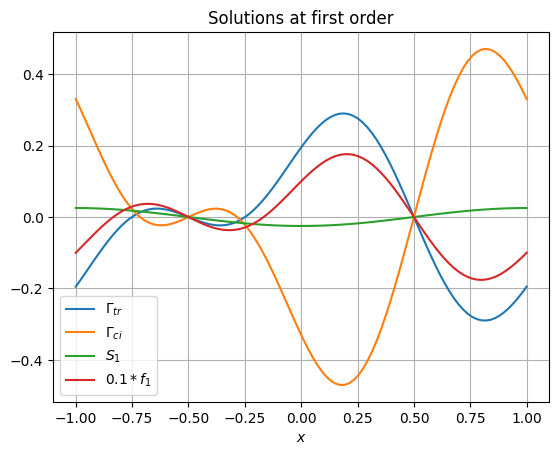

In [160]:
plt.plot(xx, ggamma_tr.real, label=r"$\Gamma_{tr}$")
plt.plot(xx, ggamma_ci.real, label=r"$\Gamma_{ci}$")
plt.plot(xx, SS.real, label=r"$S_1$")
# plt.plot(xx, np.array([f_1(x) for x in xx]), label=r"$f_1$")  # Original light intensity
plt.plot(xx, 0.1*ff_inv.real, label=r"$0.1 * f_1$")  # Interpolated light intensity
plt.xlabel(r"$x$")
plt.title("Solutions at first order")
plt.legend()
plt.grid()
plt.show()

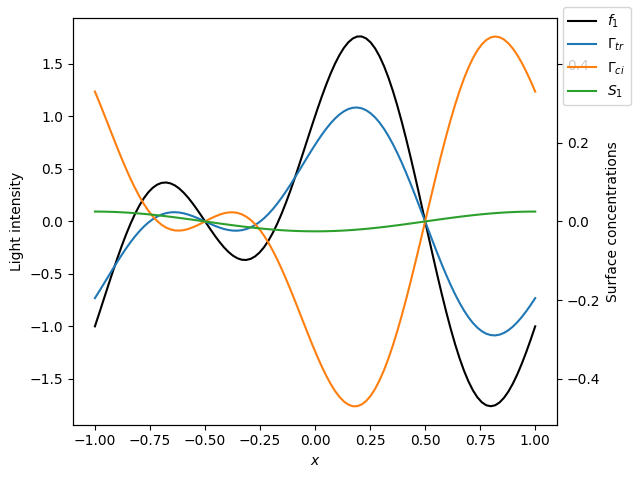

In [162]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(xx, ff_inv.real, label=r"$f_1$", color="black")

ax2.plot(xx, ggamma_tr.real, label=r"$\Gamma_{tr}$")
ax2.plot(xx, ggamma_ci.real, label=r"$\Gamma_{ci}$")
ax2.plot(xx, SS.real, label=r"$S_1$")

ax1.set_xlabel(r"$x$")
ax1.set_ylabel("Light intensity")
ax2.set_ylabel("Surface concentrations")

fig.legend()
fig.tight_layout()

fig.show()

In [161]:
print("Mean of S_1:", sols_o[-1].real)

Mean of S_1: -1.4265816688332227e-18


### Testing